In [1]:
import pandas as pd
import numpy as np
import dill
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from flask import Flask,Blueprint,request,render_template,jsonify


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
classification_report, precision_recall_curve, confusion_matrix, auc, average_precision_score

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)
df.drop(columns=['CustomerId'], inplace=True)

In [3]:
df.head(3)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
df.describe()

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


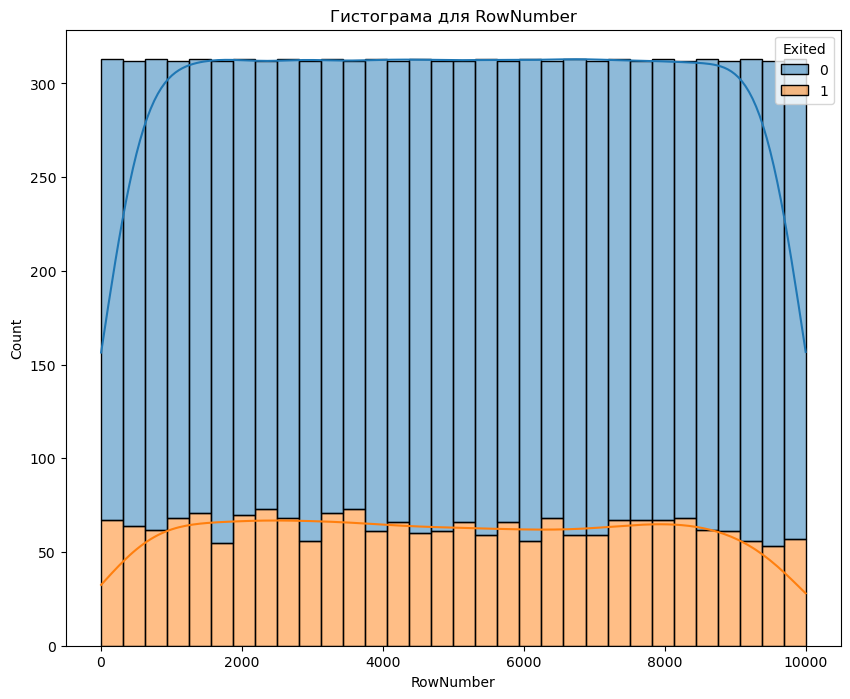

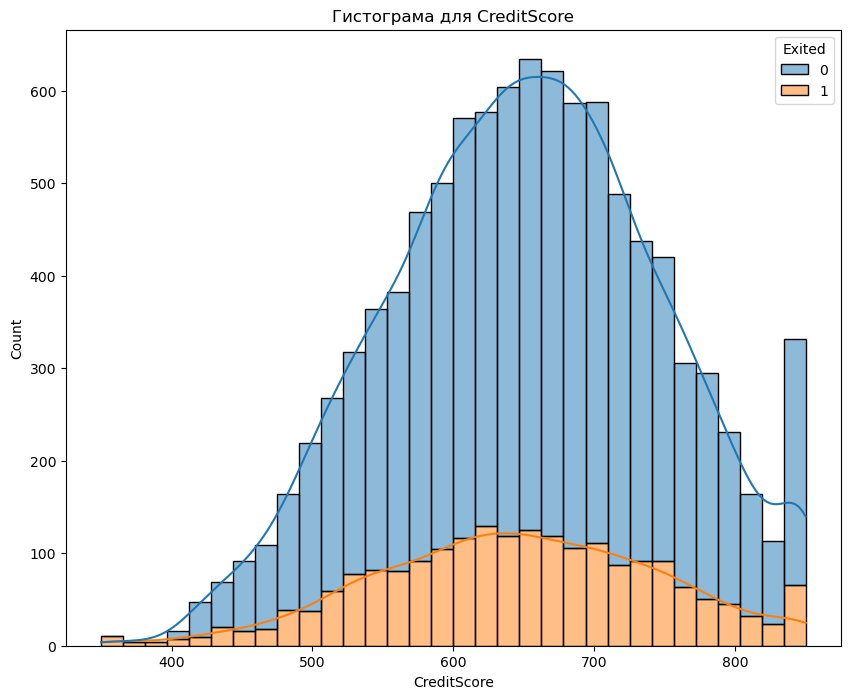

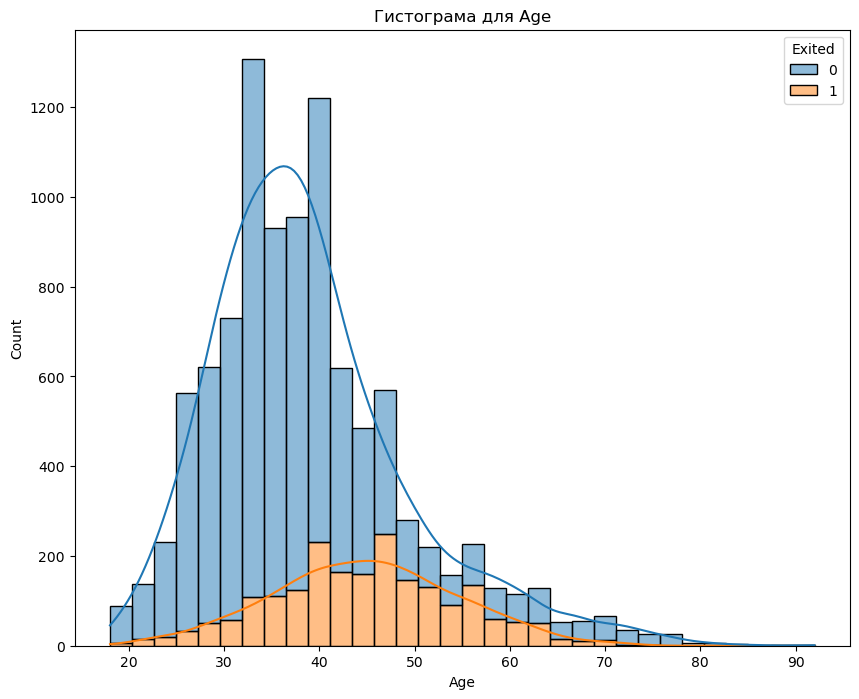

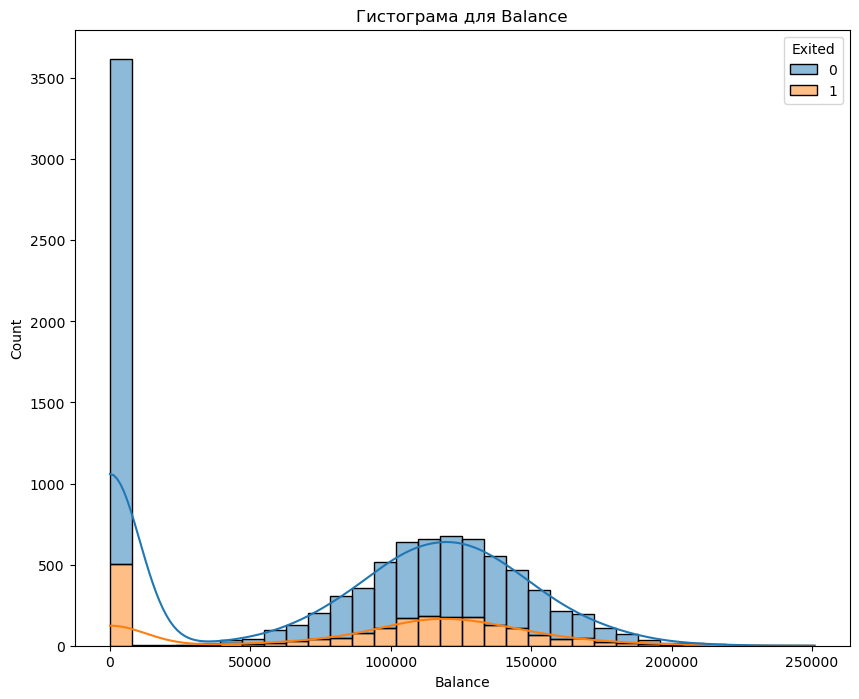

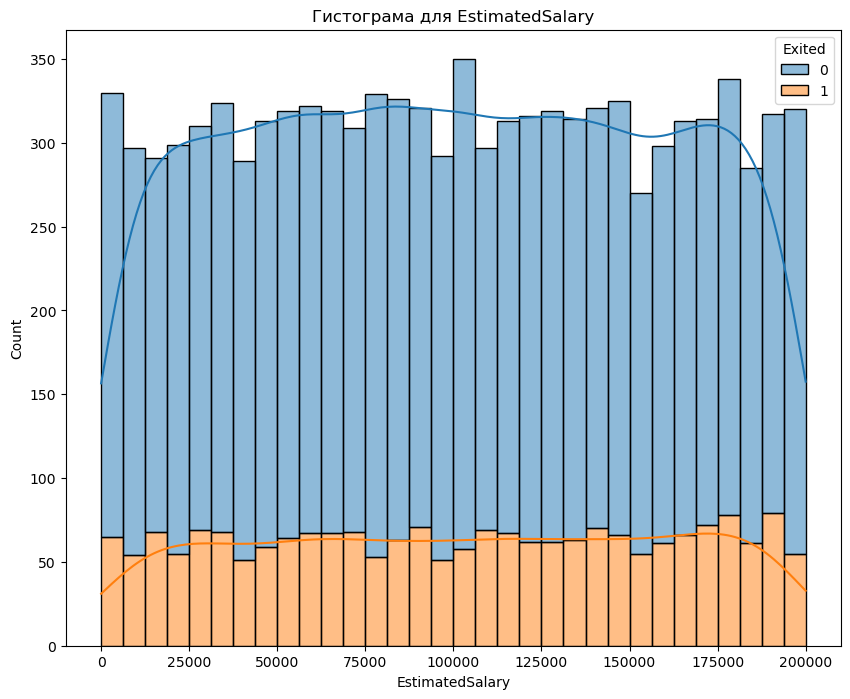

In [5]:
def num_hist(df):
    df_num = df.select_dtypes(exclude=['category', 'object'])
    df_num = df_num.drop(columns=['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'])
    for col in df_num.columns[:-1]:
        plt.figure(figsize=(10, 8))
        sns.histplot(data=df_num, x=df_num[col], bins=32, kde=True, hue=df_num['Exited'], fill=True, multiple="stack")
        plt.title("Гистограма для " + str(col))
num_hist(df)

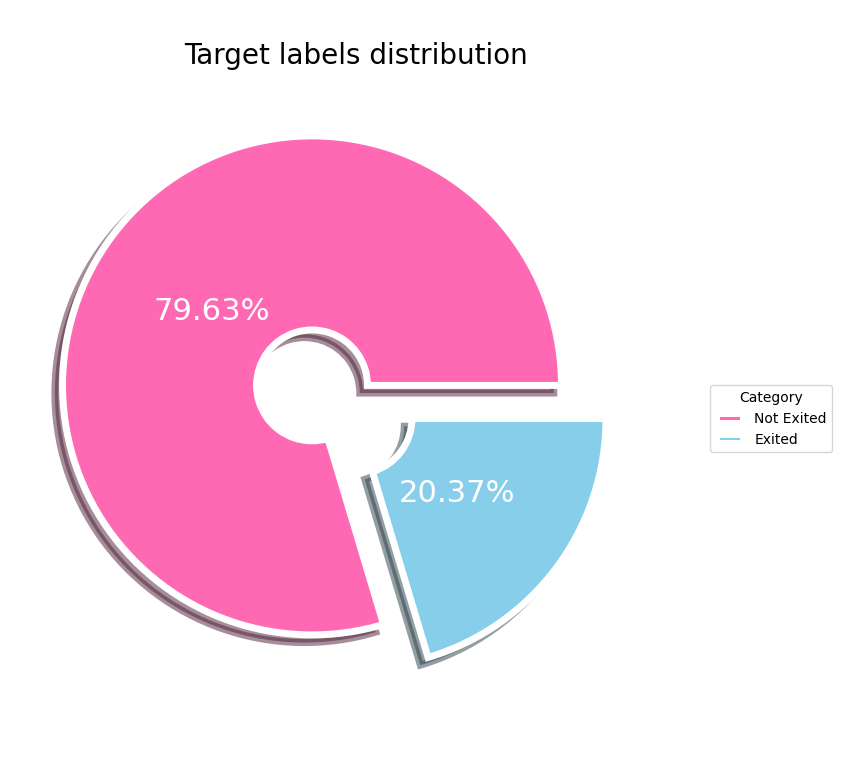

In [6]:
plt.subplots(figsize=(9, 9))

labels = "Not Exited","Exited"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["Exited"]==0]["Exited"]),
                                    len(df[df["Exited"]==1]["Exited"])],
                                    explode = (0.2,0),
                                    textprops=dict(size= 22, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9, 
                                    shadow = True, # добовляет1z эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0, colors= ['hotpink', 'skyblue'])

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nTarget labels distribution",fontsize=20)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Exited'],axis=1), df['Exited'], stratify=df['Exited'], random_state=2)

### Отбор признаков

In [8]:
cat_for_feature = CatBoostClassifier(silent=True, random_state=33, n_estimators=1600, max_depth=5)
cat_for_feature.fit(X_train, y_train, cat_features=['Surname','Geography','Gender'])

In [9]:
preds=cat_for_feature.predict_proba(X_test)[:,1]
preds

array([0.23872312, 0.24655069, 0.04107872, ..., 0.01638931, 0.92293259,
       0.01482155])

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (7, len(feature_importances) * 0.3))
    
    sns.barplot(x=feature_importances['importance'][:get_top], y=feature_importances['feature'][:get_top])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

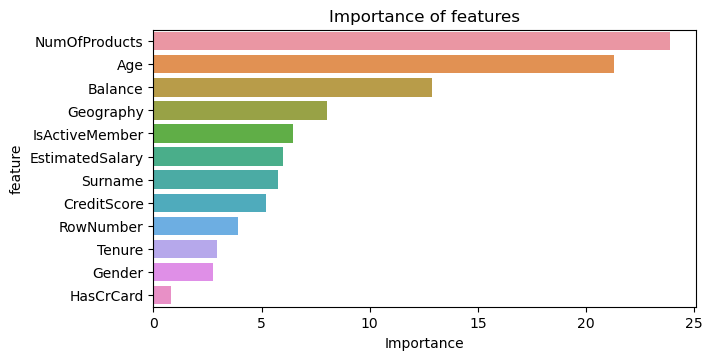

In [12]:
show_feature_importances(X_train.columns, cat_for_feature.feature_importances_)

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.297388, F-Score=0.638, Precision=0.626, Recall=0.650


Confusion matrix, without normalization
[[1793  198]
 [ 178  331]]


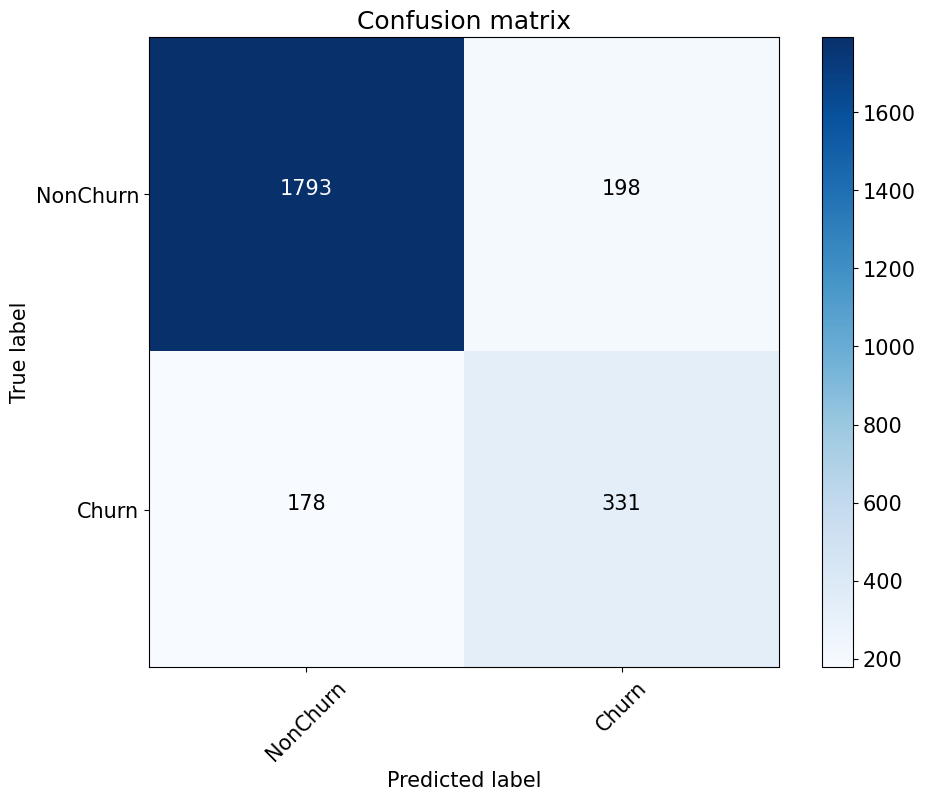

In [14]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Удалим 4 признака с самым меньшим вкладом в эфиктивность модели а так же признак Surname поскольку данный признак может лишь навредить модели в будующем при появлении новых фамилий которых нет в тренировочном датасете.

In [15]:
X_train.drop(columns=['HasCrCard','Gender', 'Tenure', 'RowNumber','Surname'], inplace=True)
X_test.drop(columns=['HasCrCard','Gender', 'Tenure', 'RowNumber', 'Surname'], inplace=True)

In [16]:
cat_for_feature = CatBoostClassifier(silent=True, random_state=33, n_estimators=1600, max_depth=5)
cat_for_feature.fit(X_train, y_train, cat_features=['Geography'])

In [17]:
preds=cat_for_feature.predict_proba(X_test)[:,1]

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.382294, F-Score=0.643, Precision=0.710, Recall=0.587


#### При удалении 5 признаков метрика FScore повысилась с 0.638 до 0.643 признаки 'HasCrCard','Gender', 'Tenure', 'RowNumber' можно отбросить

Confusion matrix, without normalization
[[1869  122]
 [ 210  299]]


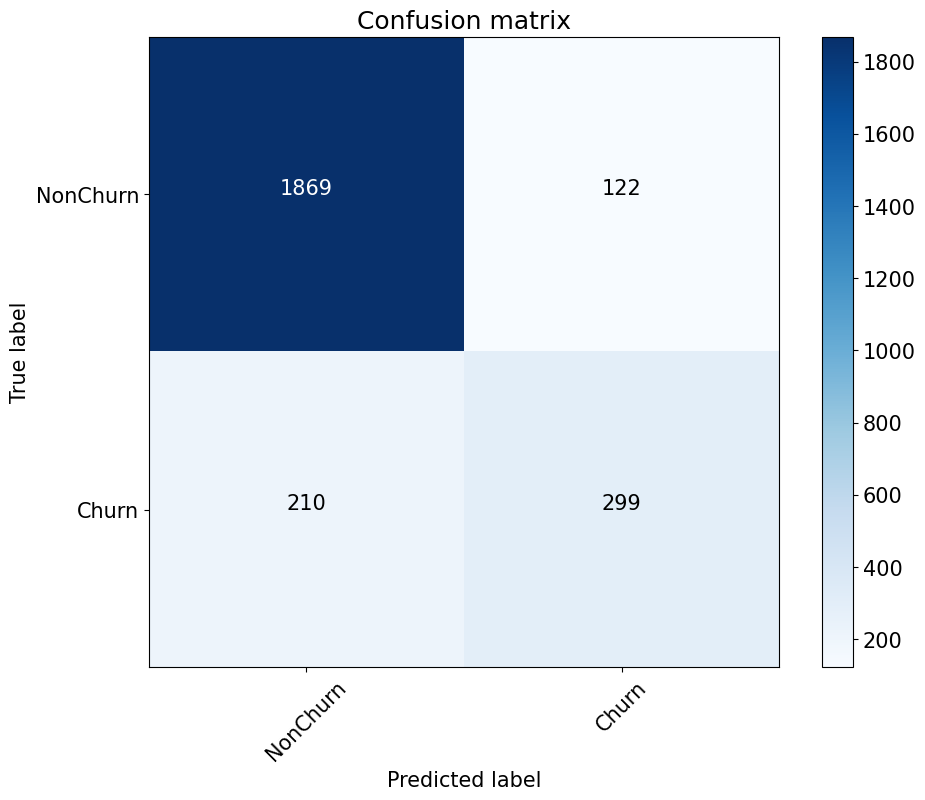

In [19]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [20]:
# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [21]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")
X_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")

### Создание Pipline

In [22]:
categorical_columns = ['Geography']
continuous_columns = ['CreditScore', 'Age','Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_bin_columns = ['IsActiveMember']

In [23]:

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p=2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index, columns =[self.columns] )
        return B[self.columns]

In [25]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('pow_3', NumericPower(key=cont_col, p=3)),
                ('Scale', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    

isActiveMember =  Pipeline([
                ('selector', FeatureSelector(column='IsActiveMember')),
                ('ohe', OHEEncoder(key='IsActiveMember'))
                ])
                 
final_transformers.append(('isActiveMember', isActiveMember))

In [26]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(random_state=33, silent=True, n_estimators=1425, max_depth=4)),
])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('CreditScore',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('pow_3',
                                                                  NumericPower(key='CreditScore',
                                                                               p=4)),
                                                                 ('Scale',
                                                                  StandardScaler())])),
                                                ('Age',
                                                 Pipeline(step...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('pow_3',
                                                                  NumericPower(key='EstimatedSalary',
                                                                               p=4)),
                                                                 ('Scale',
                                                                  StandardScaler())])),
                                                ('isActiveMember',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='IsActiveMember')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='IsActiveMember'))]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002E7CB61D790>)])

In [28]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

### Метрики для Итоговой модели

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.392413, F-Score=0.643, Precision=0.721, Recall=0.580


Confusion matrix, without normalization
[[1877  114]
 [ 214  295]]


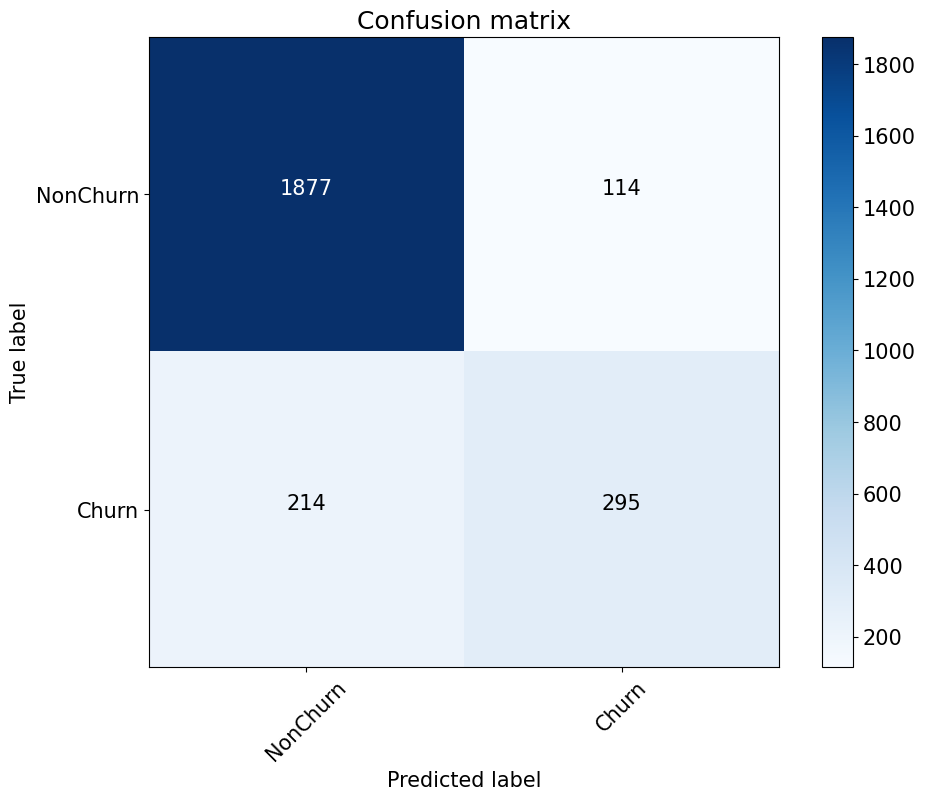

In [30]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [31]:
with open("pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

In [32]:
with open('pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

### Запуск сервера на Flask

In [ ]:
# Обработчики и запуск Flask
app = Flask(__name__)

@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    CreditScore, Geography, Age, Balance, NumOfProducts,  EstimatedSalary, IsActiveMember = 0, "", 0, 0, 0, 0, 0
    request_json = request.get_json()

    if request_json["CreditScore"]:
        CreditScore = request_json['CreditScore']

    if request_json["Geography"]:
        Geography = request_json['Geography']

    if request_json["Age"]:
        Age = request_json['Age']
        
    if request_json["Balance"]:
        Balance = request_json['Balance']

    if request_json["NumOfProducts"]:
         NumOfProducts = request_json['NumOfProducts']
            
    if request_json["IsActiveMember"]:
         IsActiveMember = request_json['IsActiveMember']

        
    if request_json["EstimatedSalary"]:
        EstimatedSalary = request_json['EstimatedSalary']
        
    df_for_pred = pd.DataFrame({"CreditScore": [CreditScore],
                                              "Geography": [Geography],
                                              "Age": [Age],
                                              "Balance": [Balance],
                                              "NumOfProducts": [NumOfProducts],
                                              "IsActiveMember": [IsActiveMember], 
                                              "EstimatedSalary":[EstimatedSalary]     
                                             })

    preds = pipeline.predict_proba(df_for_pred)
    

    
    data["predictions"] = preds[:, 1][0]
        # indicate that the request was a success
    data["success"] = True
    
    print('OK')
    print(df_for_pred)
    if data["predictions"] <= 0.395248:
        print('Charm', 'score - ', data["predictions"])
    else:
        print('Not Charm')


        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run(debug=False, host='192.168.0.106', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.0.106:5000
Press CTRL+C to quit
192.168.0.106 - - [18/Sep/2023 21:35:23] "POST /predict HTTP/1.1" 200 -


OK
   CreditScore Geography  Age  Balance  NumOfProducts  IsActiveMember  \
0          767      Hill   56     3525              3               1   

   EstimatedSalary  
0          1313413  
Not Charm


192.168.0.106 - - [18/Sep/2023 21:35:40] "POST /predict HTTP/1.1" 200 -


OK
   CreditScore Geography  Age  Balance  NumOfProducts  IsActiveMember  \
0          900      Hill   56     3525              3               0   

   EstimatedSalary  
0          1313413  
Not Charm


192.168.0.106 - - [18/Sep/2023 21:35:51] "POST /predict HTTP/1.1" 200 -


OK
   CreditScore Geography  Age  Balance  NumOfProducts  IsActiveMember  \
0           20      Hill   56     3525              3               0   

   EstimatedSalary  
0          1313413  
Not Charm


192.168.0.106 - - [18/Sep/2023 21:36:05] "POST /predict HTTP/1.1" 200 -


OK
   CreditScore Geography  Age  Balance  NumOfProducts  IsActiveMember  \
0           20      Hill   56       35              3               0   

   EstimatedSalary  
0                1  
Not Charm


192.168.0.106 - - [18/Sep/2023 21:36:51] "POST /predict HTTP/1.1" 200 -


OK
   CreditScore Geography  Age  Balance  NumOfProducts  IsActiveMember  \
0            0  Hargrave    0        0              0               0   

   EstimatedSalary  
0                0  
Not Charm


192.168.0.106 - - [18/Sep/2023 21:39:17] "POST /predict HTTP/1.1" 200 -


OK
   CreditScore Geography  Age   Balance  NumOfProducts  IsActiveMember  \
0          608     Spain   41  83807.86              1               1   

   EstimatedSalary  
0        112542.58  
Charm score -  0.1508081349934226


In [ ]:
df